## Optimize DiaSource access in l1dbproto

testing various options for DiaSource table access.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

import plots
plots.plot_width = 8

# plots to draw in do_plots_all()
all_plots = ['select_real', 'store_real',
             'obj_select_real', 'obj_last_insert_real',
             'obj_insert_real', 'obj_store',
             'src_select_real', 'src_insert_real',
             'fsrc_select_real', 'fsrc_insert_real']

## Region-based access for DiaSource

In previous tests DiaSource was read using DiaObject IDs, I think in my very early tests with MySQL/Postgres I compared ID-based select with region-based and ID-based one was faster (but apparently I have no record of that in notebooks). I want to repeat comparison with Oracle to quantify the effect.

Naively it would seem that both types of selects should performs similarly:

- DiaSource PK is diaSourceId
- access based on DiaObject ID should be using index on diaObjectId column
- similarly region-based access should be using index on pixelId column
- difference in SELECT is equality match `WHERE diaObjectId IN (:id1, :id2, :id3)` vs. `WHERE pixelId BETWEEN :p1 AND :p2 OR pixelId BETWEEN :p3 and :p4 ...`, range-based select may be mode complicated for optimizer (but should not be)
- another difference is that region-based select will return more data that needed as region envelope will always be larger, how many more depends on few factors, but typically will be 50-100% more (which may be important as we include history of all selected sources).


## First broken test

In first attemp to use region-based select I implemented it using integer literals in `BETWEEN` instead of parametrized form (it was dragged from old implementation for MySQL). Oracle did not like that very much, apparently optimizer optimizes things differently depending on whether one uses literals or parameters in expressions.

Lesson here is of course to always use parameters with Oracle queries.

In the plots below visits 1-1627, 2628-3627, and 30471-31470 used region-based select, while all other visits were ID-based.

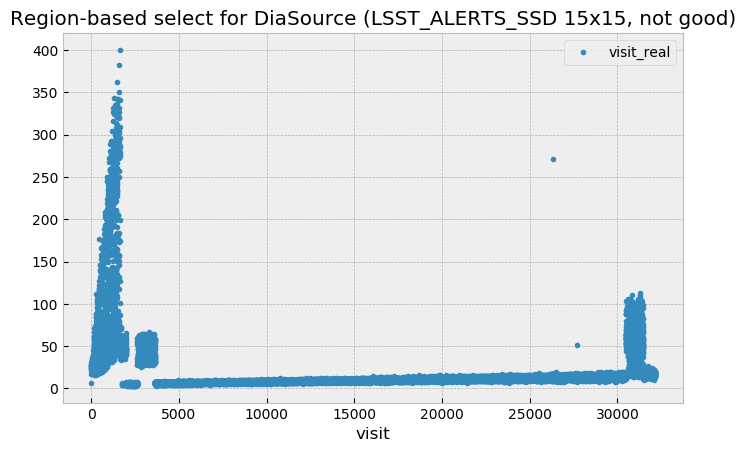

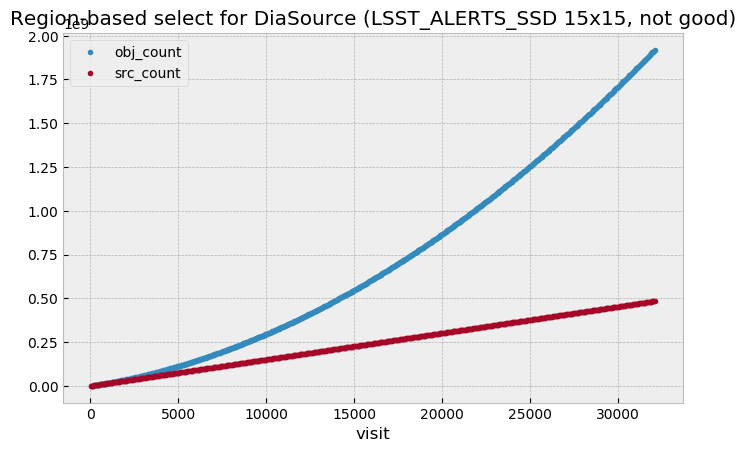

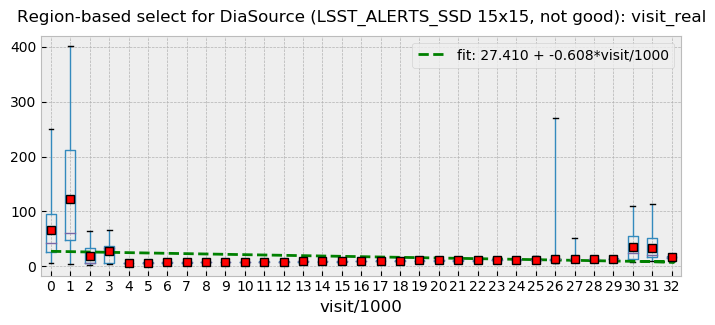

In [2]:
csv = "data/dm-15476-oracle-ssd-15x15-source-region-20180820T174350.csv.gz"
title = "Region-based select for DiaSource (LSST_ALERTS_SSD 15x15, not good)"
ds = plots.do_plots(csv, title, bin=1000, filter_count=True)

## Better attempt with parameters

Re-implementing same SELECT using parameters (exactly the same way as we do with DiaObject), it has much improved performance compared to previous one, but it is somewhat slower than ID-based select.

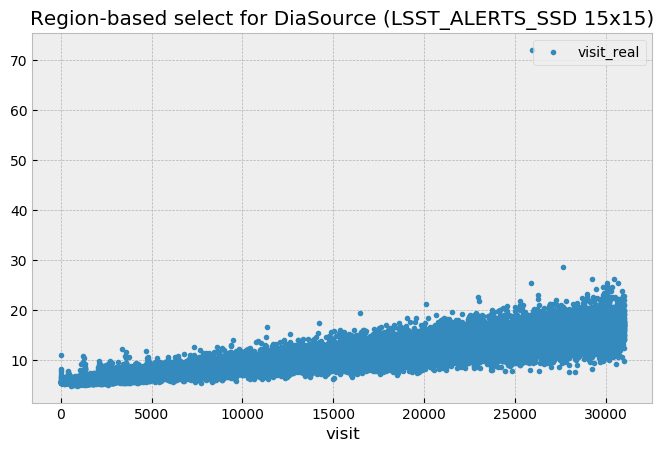

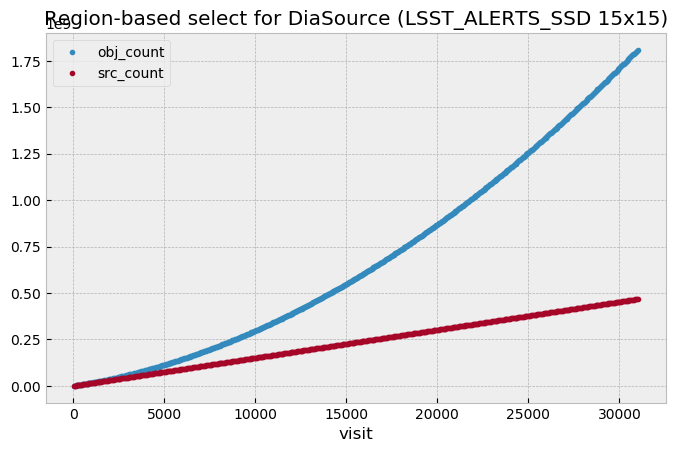

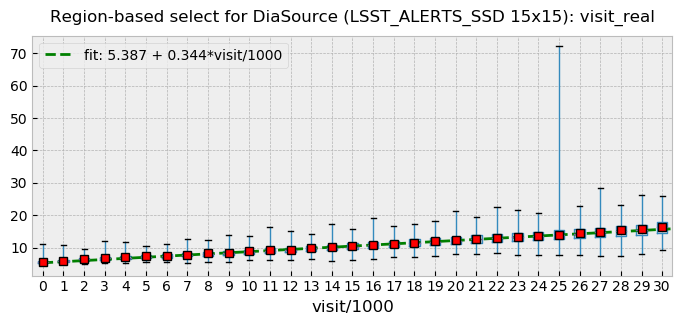

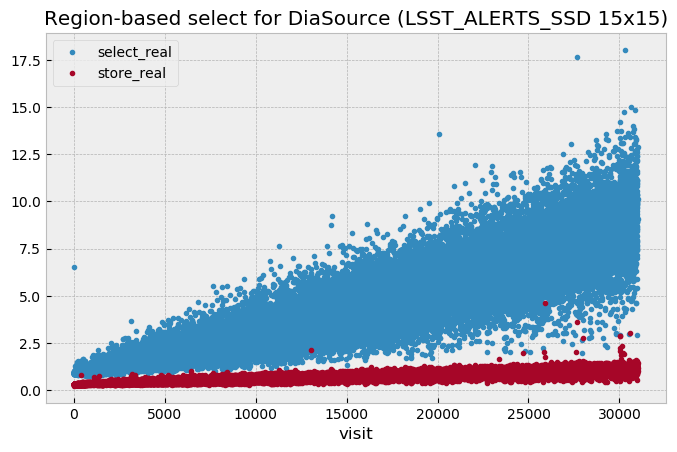

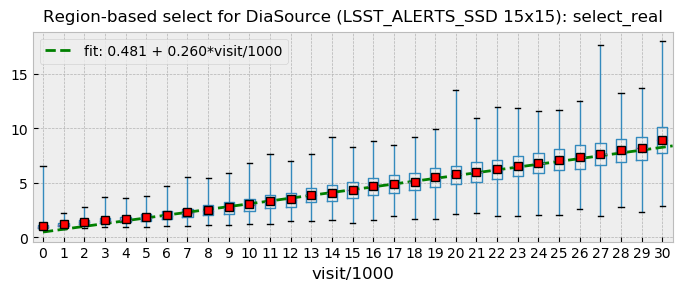

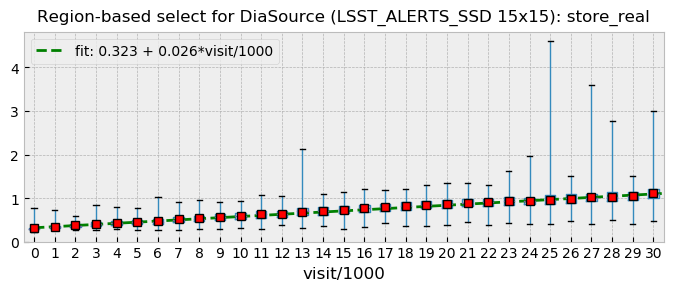

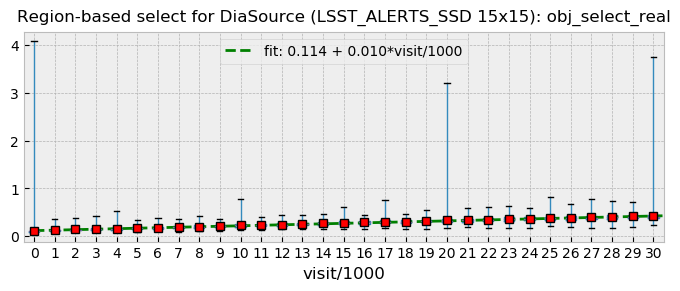

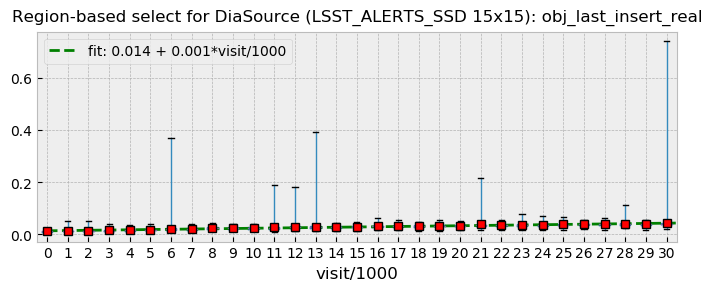

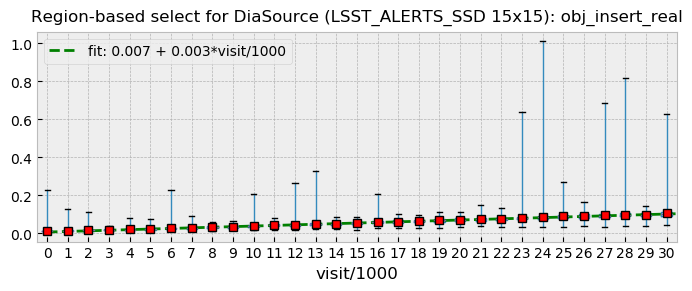

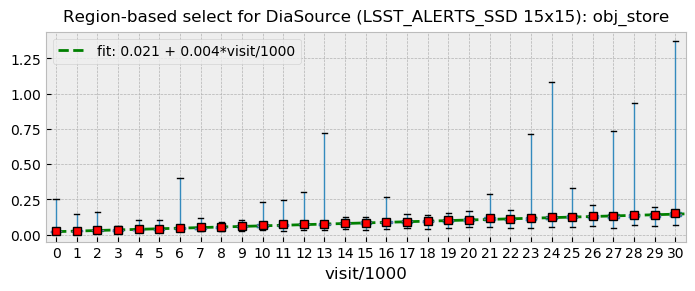

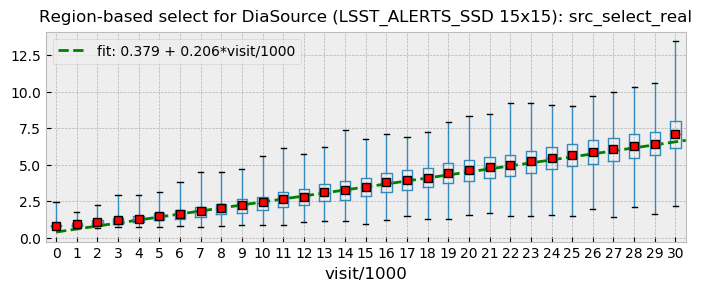

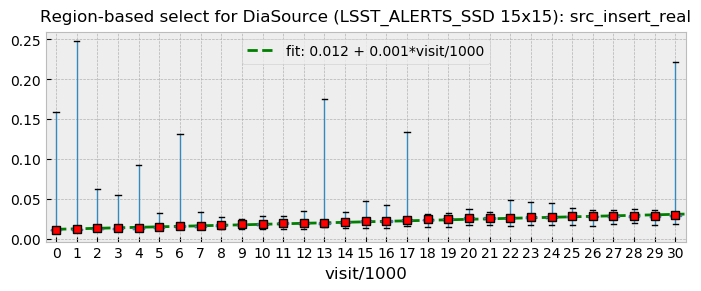

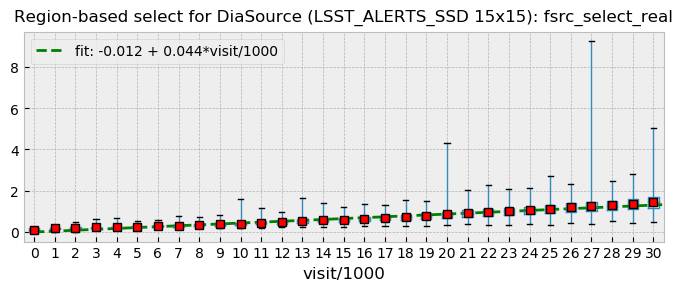

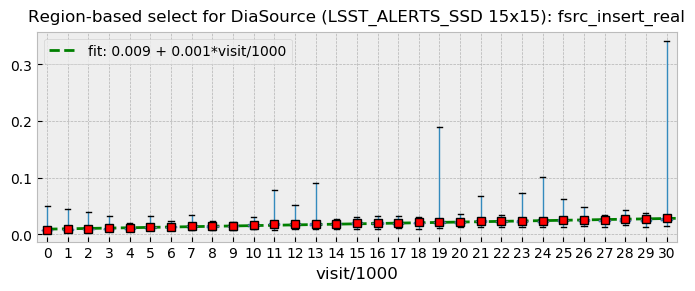

In [3]:
csv = "data/dm-15476-oracle-ssd-15x15-source-region2-20180901T145600.csv.gz"
title = "Region-based select for DiaSource (LSST_ALERTS_SSD 15x15)"
ds = plots.do_plots(csv, title, bin=1000, filter_count=True)
ds = plots.do_plots_all(ds, title, bin=1000, filter_count=True, plots=all_plots)

# Granularity for spatial select

Check what happens with different HTM_MAX_RANGES values.

In `dm-15476-oracle-ssd-15x15-source-region4.csv` I ran `ap_proto` with different HTM_MAX_RANGES values:

| Visits  | HTM_MAX_RANGES  |
|---------|-----------------|
| 1-21324 | 64              |
| 21325-23324 | 32          |
| 23325-25324 | 128         |

In [4]:
csv = "data/dm-15476-oracle-ssd-15x15-source-region4.csv.gz"
ds, dsc = plots._read_csv(csv)
ds["obj_filter"] = ds.obj_in_fov / ds.obj_selected
ds64 = ds[ds.index<21325]
ds32 = ds[(ds.index>=21325) & (ds.index<23325)]
ds128 = ds[ds.index>=23325]

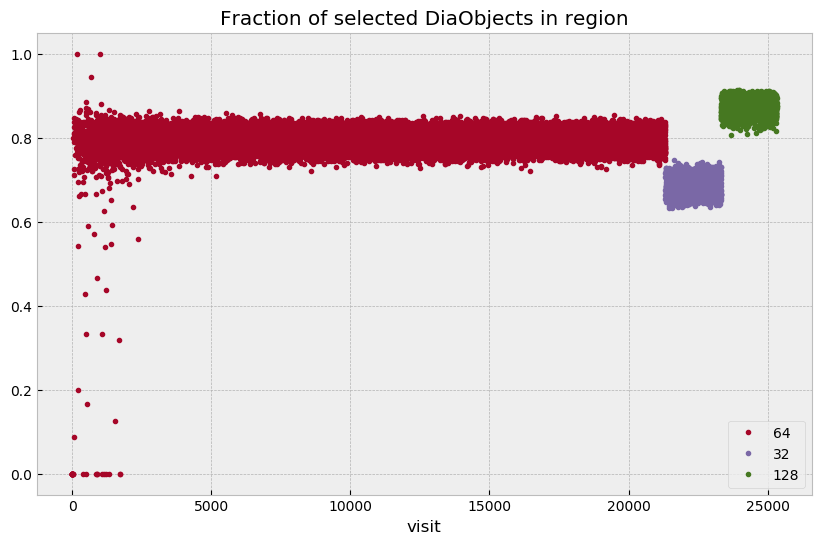

In [5]:
ax = ds64.plot(y=["obj_filter"], style=['.C1'], title="Fraction of selected DiaObjects in region", figsize=(10,6));
ds32.plot(y=["obj_filter"], style=['.C2'], ax=ax);
ds128.plot(y=["obj_filter"], style=['.C3'], ax=ax);
ax.legend(['64', '32', '128'])

In [6]:
for n, df in ((32, ds32), (64, ds64), (128, ds128)):
    print("{:3d}: {:.2f}".format(n, df[df.index>5000].obj_filter.mean()))

 32: 0.68
 64: 0.79
128: 0.87


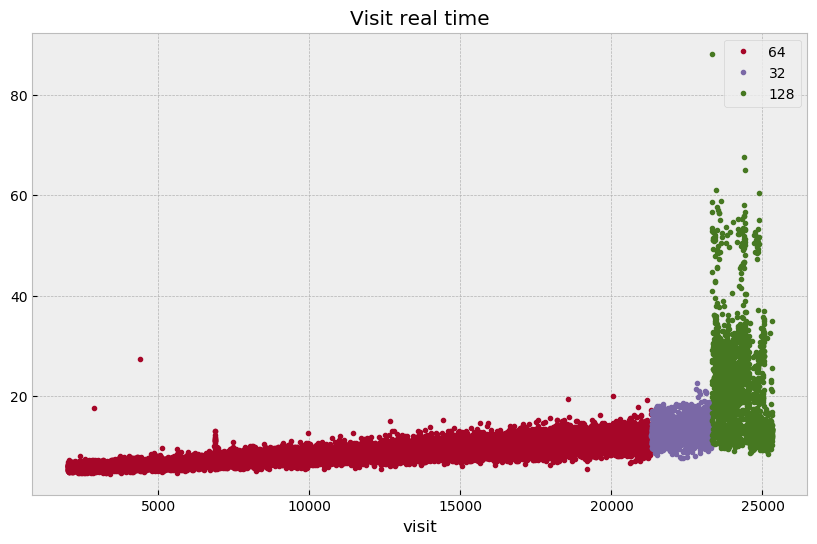

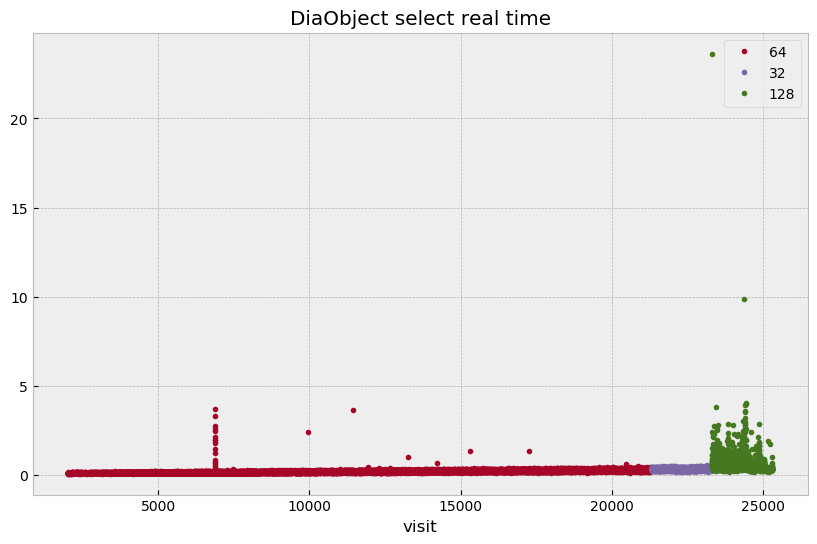

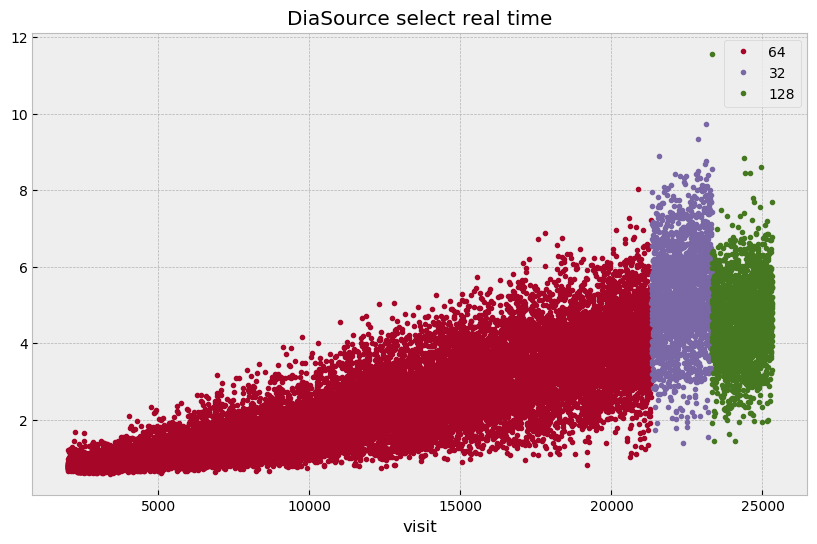

In [7]:
plots = [("visit_real", "Visit real time"),
         ("obj_select_real", "DiaObject select real time"),
         ("src_select_real", "DiaSource select real time")]
for col, title in plots:
    ax = ds64[ds64.index>2000].plot(y=[col], style=['.C1'], title=title, figsize=(10,6));
    ds32.plot(y=[col], style=['.C2'], ax=ax);
    ds128.plot(y=[col], style=['.C3'], ax=ax);
    ax.legend(['64', '32', '128'])